In [1]:
import subprocess
import os
import ete3
import random
import numpy as np
from Bio import SeqIO
import pandas as pd
import multiprocessing
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, linregress

#
# initial definitions
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

%cd /work/site_rate/sequence_simulation
%matplotlib inline
num_replicates      = 100
sequence_length     = 5000
num_rate_categories = 12

/work/site_rate/sequence_simulation


In [2]:
random.seed(12345)
np.random.seed(12345)

indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - site-rate project                               //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   12345

[MODEL] model1  [submodel]  LG         //   LG
                [rates]     0 1.3 20    //   pinv=0, alpha=1.3, discrete gamma categories=20
                [statefreq]
                    0.083   0.078   0.035   0.059   // list of 20 numbers
                    0.006   0.031   0.082   0.080   // A R N D C
                    0.018   0.063   0.070   0.078   // Q E G H I
                    0.025   0.025   0.046   0.050   // L K M F P
                    0.054   0.008   0.025   0.084   // S T W Y V

[MODEL] modelHug [submodel]  LG                         //   LG
                 [rates]     0 0.8025 20                //   pinv=0, alpha=1.3, discrete gamma categories=20
                 [statefreq]
                    0.0790   0.0843   0.0346   0.0392   // list of 20 numbers
                    0.0055   0.0293   0.0535   0.0956   // A R N D C
                    0.0217   0.0704   0.0699   0.1008   // Q E G H I
                    0.0253   0.0280   0.0415   0.0519   // L K M F P
                    0.0516   0.0065   0.0217   0.0898   // S T W Y V

[MODEL] modelHemimastigophora [submodel]  LG            //   LG
                 [rates]     0 0.8025 20                //   pinv=0, alpha=0.8648, discrete gamma categories=20
                 [statefreq]
                    0.0801  0.0593  0.0369  0.0535   // list of 20 numbers
                    0.0173  0.0340  0.0623  0.0677   // A R N D C
                    0.0226  0.0648  0.1001  0.0630   // Q E G H I
                    0.0269  0.0429  0.0389  0.0549   // L K M F P
                    0.0515  0.0102  0.0325  0.0804   // S T W Y V

[TREE] T1  {t1}
[TREE] T2  {t2}
[TREE] T3  {t3}

[PARTITIONS] partition1 [T1 modelHug {length}]   // tree T1, model model1, root length 1000
[PARTITIONS] partition2 [T2 modelHemimastigophora {length}]   // tree T2, model model1, root length 1000
[PARTITIONS] partition3 [T3 modelHug {length}]   // tree T3, model model1, root length 1000

[EVOLVE]    partition1  {num_replicates}   {t1_name}
            partition2  {num_replicates}   {t2_name}
            partition3  {num_replicates}   {t3_name}
'''

taxa_names = [f'taxa_{count:04}' for count in range(1,1001)]
base_tree  = ete3.Tree()
base_tree.populate(size=1000, names_library=taxa_names, random_branches=True)

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


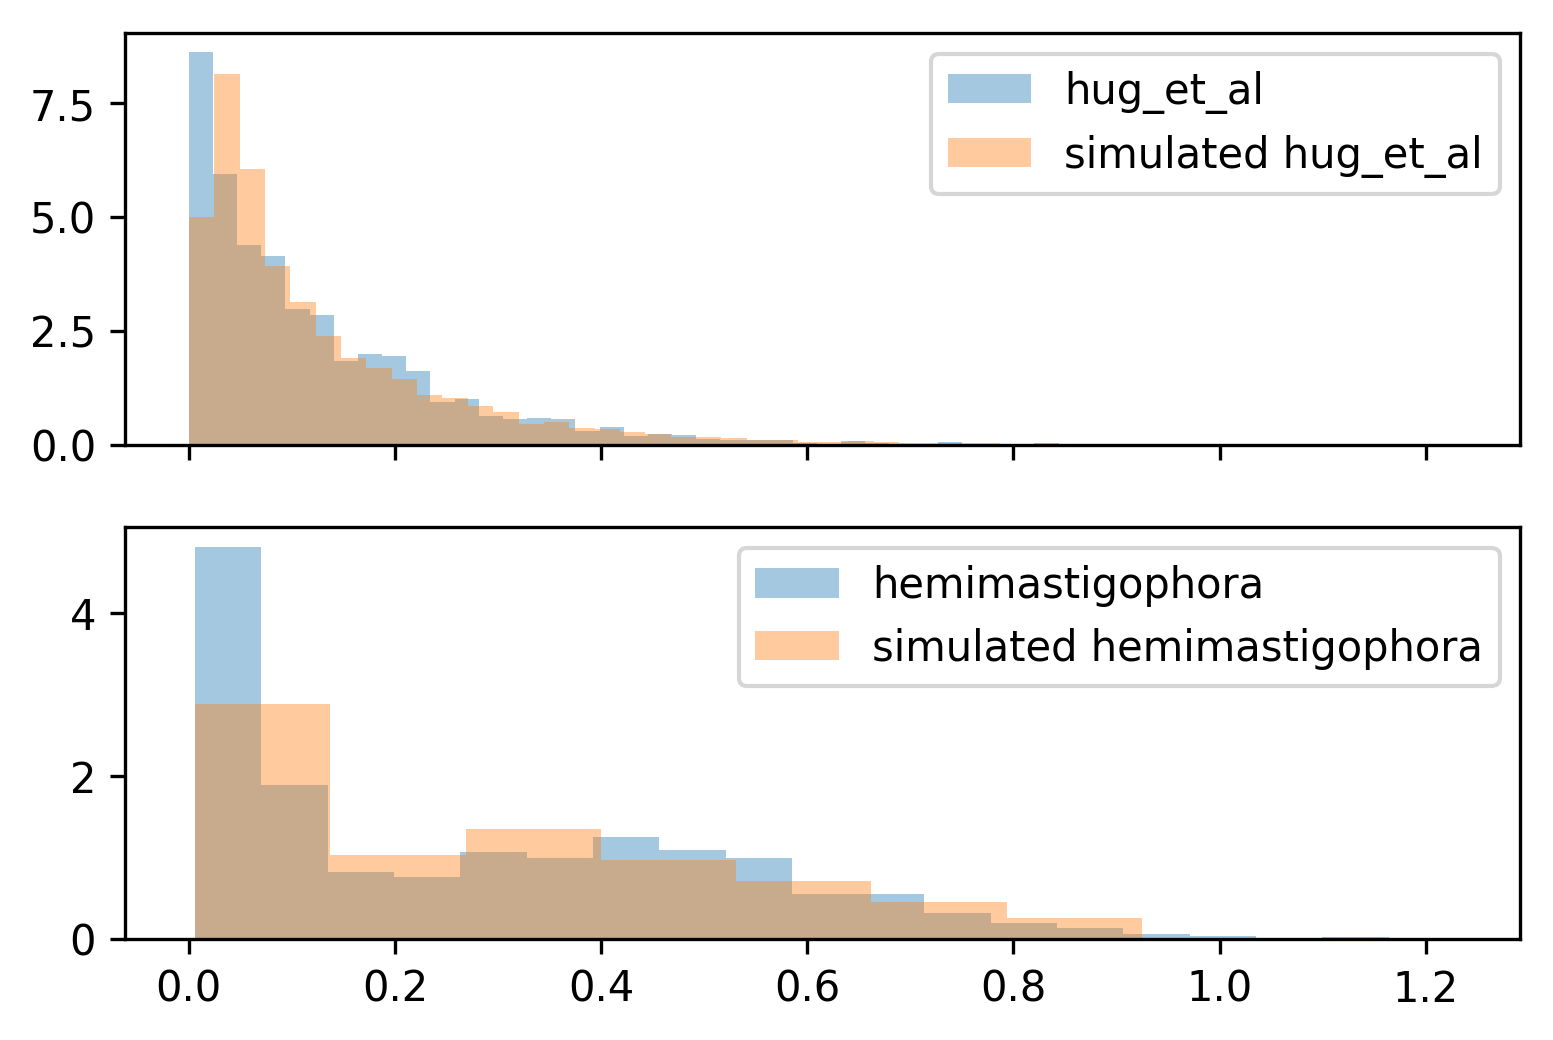

In [3]:
trees = {}
fig, axs = plt.subplots(nrows=2, dpi=300, sharex=True)
for tree_name, ax in zip('hug_et_al hemimastigophora'.split(), axs):
    tmp_tree                = ete3.Tree('../%s/species.tre' % tree_name)
    internal_branch_lengths = [node.dist for node in tmp_tree.traverse()
                               if not node.is_root() and not node.is_leaf()]
    leaf_branch_lengths     = [node.dist for node in tmp_tree.get_leaves()]

    #
    # https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy
    fit_alpha, fit_loc, fit_beta        = stats.gamma.fit(internal_branch_lengths)
    internal_branch_length_distribution = stats.gamma(fit_alpha, loc=fit_loc, scale=fit_beta)
    
    fit_alpha, fit_loc, fit_beta        = stats.gamma.fit(leaf_branch_lengths)
    terminal_branch_length_distribution = stats.gamma(fit_alpha, loc=fit_loc, scale=fit_beta)

    trees[tree_name] = base_tree.copy()
    for node in trees[tree_name].traverse():
        if node.is_root():
            continue
        elif node.is_leaf():
            tmp_branch_length = -1
            while tmp_branch_length < 0:
                tmp_branch_length = terminal_branch_length_distribution.rvs(1)[0]
            node.dist = tmp_branch_length
        else:
            tmp_branch_length = -1
            while tmp_branch_length < 0:
                tmp_branch_length = internal_branch_length_distribution.rvs(1)[0]
            node.dist = tmp_branch_length
            #node.dist = internal_branch_length_distribution.rvs(1)[0]
    
    sns.distplot([node.dist for node in trees[tree_name].traverse() if not node.is_root()],
                 ax=ax, kde=False, norm_hist=True, label=tree_name)
    sns.distplot([node.dist for node in tmp_tree.traverse() if not node.is_root()],
                 ax=ax, kde=False, norm_hist=True, label='simulated '+tree_name)
    ax.legend()

In [ ]:
out = open('control.txt', 'w')
out.write(indelible_conf.format(t1=base_tree.write(format=5, dist_formatter='%.20f'),  t1_name='random_br_length',
                                t2=trees['hemimastigophora'].write(format=5, dist_formatter='%.20f'), t2_name='hemimastigophora_br_length',
                                t3=trees['hug_et_al'].write(format=5, dist_formatter='%.20f'), t3_name='hug_br_length',
                                num_replicates=num_replicates, length=sequence_length))
out.close()

subprocess.call(['/work/site_rate/indelible/INDELibleV1.03/bin/indelible_1.03_OSX_intel'])

In [ ]:
fasta = open('hemimastigophora_br_length.fas').read().strip()
trees['hemimastigophora'].write(outfile='hemimastigophora/reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('hemimastigophora/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

fasta = open('hug_br_length.fas').read().strip()
trees['hug_et_al'].write(outfile='hug/reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('hug/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

fasta = open('random_br_length.fas').read().strip()
base_tree.write(outfile='random/reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('random/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

In [ ]:
#
# classify sites into rate-categories
def write_rates(argument):
    partition_name, replicate_number = argument
    subprocess.call(['iqtree', '-s', '%s/%i.fas' % (partition_name, replicate_number), '-m', 'LG+G12', '-redo',
                     '-safe', '-wsr', '-nt', '1', '-n', '0', '-pre', '%s/%i' % (partition_name, replicate_number),
                     '-te', '%s/reference.tre' % partition_name, '-quiet'])

In [ ]:
num_threads = 5
pool = multiprocessing.Pool(processes=num_threads)
pool.map(write_rates, product('hemimastigophora hug'.split(), range(1, num_replicates+1)))

In [ ]:
#
# parse rates classification
#
for partition_name in 'hemimastigophora hug'.split():
    print(partition_name)

    with cd(partition_name):
        if not os.path.isdir('categories'):
            os.mkdir('categories')
        else:
            os.system('rm -r categories/*')

        for replicate in range(1, num_replicates+1):
            alignment = list(SeqIO.parse('%i.fas' % replicate, 'fasta'))

            rates = pd.read_table('%i.rate' % replicate, comment='#')
            for category in rates.Cat.unique():
                site_df        = rates[rates.Cat == category]
                category_aln   = {sequence.name:'' for sequence in alignment}
                for sequence in alignment:
                    category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

                out = open('categories/%i.%i.aln' % (replicate, category), 'w')
                for header, sequence in category_aln.items():
                    full_sequence = ''
                    while len(full_sequence) <= 1000:
                        full_sequence += sequence
                    out.write('>%s\n%s\n' % (header, full_sequence[:1000]))
                out.close()

In [ ]:
def run_bootstrap(argument):
    replicate_number, category = argument
    subprocess.call(['iqtree', '-s', '%i.%i.aln' % (replicate_number, category), '-m', 'LG+G1', '-redo',
                     '-safe', '-nt', '1', '-pre', '%i.%i' % (replicate_number, category),
                     '-alrt', '1000', '-keep-ident', '-quiet', '-te', '../reference.tre'])

for partition_name in 'hemimastigophora hug'.split():
    with cd('%s/categories' % partition_name):
        pool = multiprocessing.Pool(processes=15)
        pool.map(run_bootstrap, product(range(1, num_replicates+1), range(1, 13)))

In [ ]:
%cd /work/site_rate/sequence_simulation/hug
category_support_df = pd.DataFrame(columns='replicate category topology_id support branch_length'.split())
for replicate in range(1, 101):
    for category in range(1, 13):
        tmp_tree = ete3.Tree('categories/%i.%i.treefile' % (replicate, category))

        tmp_tree.set_outgroup(base_tree.children[0].get_leaf_names()[0])
        outgroup = tmp_tree.get_common_ancestor(base_tree.children[1].get_leaf_names())
        tmp_tree.set_outgroup(outgroup)

        tmp_supports       = []
        tmp_topology_ids   = []
        tmp_branch_lengths = []
        for node in tmp_tree.traverse():
            if not node.is_leaf() and not node.is_root():
                tmp_supports.append(node.support)
                tmp_topology_ids.append(node.get_topology_id())
                tmp_branch_lengths.append(node.dist)

        tmp_df = pd.DataFrame(
               list(zip([replicate]*len(tmp_supports),
                        [category]*len(tmp_supports),
                        tmp_topology_ids,
                        tmp_supports,
                        tmp_branch_lengths)),
                    columns='replicate category topology_id support branch_length'.split())
        category_support_df = category_support_df.append(tmp_df, ignore_index=True)

    for node in trees['hug_et_al'].traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_topology_id = node.get_topology_id()
            category_support_df.loc[category_support_df.topology_id == tmp_topology_id, 'branch_length'] = node.dist

    category_support_df.to_csv('category_supports.tab', sep='\t')

In [ ]:
%cd /work/site_rate/sequence_simulation/hug
category_support_df = pd.read_table('category_supports.tab', index_col=0)
category_support_df.head()

In [ ]:
fig, axs = plt.subplots(dpi=90, nrows=10)
for replicate, ax in enumerate(axs, 1):
    tmp_df = category_support_df[category_support_df.replicate == replicate].copy()
    
    branch_lengths = tmp_df.loc[
        tmp_df.category == 2,
        'branch_length'.split()].values.squeeze()

    branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
    binning            = np.digitize(tmp_df['branch_length'].values.squeeze(), branch_length_bins)
    bin_names          = {}

    for bin in set(binning):
        min_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
        max_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
        bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

    tmp_df['branch_length_bin'] = [bin_names[bin] for bin in binning]
    
    sns.boxplot(x='branch_length_bin', y='support', hue='category',
                order=bin_names.values(), data=tmp_df, ax=ax)
    fig.set_size_inches(25,6)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category', frameon=False)
fig.set_size_inches(20,50)

In [ ]:
for node in trees['hug_et_al'].traverse():
    if node.is_root() or node.is_leaf():
        continue
    node.add_feature('topology_id', node.get_topology_id())

In [ ]:
%cd /work/site_rate/sequence_simulation/hemimastigophora
category_support_df2 = pd.DataFrame(columns='replicate category topology_id support branch_length'.split())
for replicate in range(1, 101):
    for category in range(1, 13):
        tmp_tree = ete3.Tree('categories/%i.%i.treefile' % (replicate, category))

        tmp_tree.set_outgroup(base_tree.children[0].get_leaf_names()[0])
        outgroup = tmp_tree.get_common_ancestor(base_tree.children[1].get_leaf_names())
        tmp_tree.set_outgroup(outgroup)

        tmp_supports       = []
        tmp_topology_ids   = []
        tmp_branch_lengths = []
        for node in tmp_tree.traverse():
            if not node.is_leaf() and not node.is_root():
                tmp_supports.append(node.support)
                tmp_topology_ids.append(node.get_topology_id())
                tmp_branch_lengths.append(node.dist)

        tmp_df = pd.DataFrame(
               list(zip([replicate]*len(tmp_supports),
                        [category]*len(tmp_supports),
                        tmp_topology_ids,
                        tmp_supports,
                        tmp_branch_lengths)),
                    columns='replicate category topology_id support branch_length'.split())
        category_support_df2 = category_support_df2.append(tmp_df, ignore_index=True)

    for node in trees['hemimastigophora'].traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_topology_id = node.get_topology_id()
            category_support_df2.loc[category_support_df2.topology_id == tmp_topology_id, 'branch_length'] = node.dist

    category_support_df2.to_csv('category_supports.tab', sep='\t')

In [ ]:
fig, axs = plt.subplots(dpi=90, nrows=10)
for replicate, ax in enumerate(axs, 1):
    tmp_df = category_support_df2[category_support_df2.replicate == replicate].copy()
    
    branch_lengths = tmp_df.loc[
        tmp_df.category == 2,
        'branch_length'.split()].values.squeeze()

    branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
    binning            = np.digitize(tmp_df['branch_length'].values.squeeze(), branch_length_bins)
    bin_names          = {}

    for bin in set(binning):
        min_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
        max_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
        bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

    tmp_df['branch_length_bin'] = [bin_names[bin] for bin in binning]
    
    sns.boxplot(x='branch_length_bin', y='support', hue='category',
                order=bin_names.values(), data=tmp_df, ax=ax)
    fig.set_size_inches(25,6)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category',frameon=False)
fig.tight_layout()
fig.set_size_inches(20,50)

In [ ]:
branch_lengths = category_support_df.loc[
        (category_support_df.category  == 1)&
        (category_support_df.replicate == 1),
        'branch_length'.split()].values.squeeze()

branch_length_bins                        = [np.percentile(branch_lengths, decile) 
                                             for decile in range(10, 91, 10)]
category_support_df['branch_length_bins'] = np.digitize(category_support_df['branch_length'].values.squeeze(), 
                                                        branch_length_bins)

branch_lengths = category_support_df2.loc[
        (category_support_df2.category  == 1)&
        (category_support_df2.replicate == 1),
        'branch_length'.split()].values.squeeze()

branch_length_bins                         = [np.percentile(branch_lengths, decile) 
                                             for decile in range(10, 91, 10)]
category_support_df2['branch_length_bins'] = np.digitize(category_support_df2['branch_length'].values.squeeze(), 
                                                        branch_length_bins)

In [ ]:
category_support_df2.shape

In [ ]:
pvalues   = []
for bins, category in product(['4_2', '4_6', '4_9', '5_0', '5_4'], range(1, 13)):
    bin1,bin2 = bins.split('_')
    tmp_support = category_support_df.loc[(category_support_df['branch_length_bins']==int(bin1))&
                                          (category_support_df.category==category),
                                          'support'].tolist()
    tmp_support2 = category_support_df2.loc[(category_support_df2['branch_length_bins']==int(bin2))&
                                            (category_support_df2.category==category),
                                            'support'].tolist()
    mw = stats.mannwhitneyu(tmp_support, tmp_support2)
    delta = np.mean(tmp_support)-np.mean(tmp_support2)

    if mw.pvalue > 0.05:
        continue
        
    if delta > 0:
        print('%s %i hug' % (bins, category))
    else:
        print('%s %i lax' % (bins, category))

In [ ]:
pvalues   = []
deltamean = []
for branch_length_bin, category in product(category_support_df.branch_length_bins.unique(), range(1, 13)):
    tmp_support = category_support_df.loc[(category_support_df['branch_length_bins']==branch_length_bin)&
                                          (category_support_df.category==category),
                                          'support'].tolist()
    tmp_support2 = category_support_df2.loc[(category_support_df2['branch_length_bins']==branch_length_bin)&
                                            (category_support_df2.category==category),
                                            'support'].tolist()
    pvalues.append(  stats.mannwhitneyu(tmp_support, tmp_support2).pvalue)
    deltamean.append(np.mean(tmp_support)-np.mean(tmp_support2))

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
better_outcome = []
for reject, delta, (branch_length_bin, category) in zip(fdrcorrection(pvalues)[0],
                         deltamean,
                         product(category_support_df.branch_length_bins.unique(), range(1, 13))):
    if not reject:
        continue
    if delta > 0:
        print('%i %i hug' % (branch_length_bin, category))
        better_outcome.append('hug')
    else:
        print('%i %i lax' % (branch_length_bin, category))
        better_outcome.append('lax')

In [ ]:
len(list(product(category_support_df.branch_length_bins.unique(), range(1, 13))))

In [ ]:
pvalues = []
values  = []
br_lens = []
for branch_length_bin1, branch_length_bin2  in product(range(10), repeat=2):
    br_lens1 = category_support_df.loc[(category_support_df['branch_length_bins']==branch_length_bin1)&
                                       (category_support_df.replicate==1),
                                       'branch_length'].tolist()
    br_lens2 = category_support_df.loc[(category_support_df2['branch_length_bins']==branch_length_bin2)&
                                       (category_support_df2.replicate==1),
                                       'branch_length'].tolist()
    pvalues.append(stats.mannwhitneyu(br_lens1, br_lens2).pvalue*2.0)
    values.append('%i_%i' % (branch_length_bin1, branch_length_bin2))
    br_lens.append([br_lens1, br_lens2])

In [ ]:
fig, axs = plt.subplots(nrows=5, sharex=False, dpi=300, figsize=(3,8))
ax_count = -1
for key, value, br_len in zip(values, fdrcorrection(pvalues)[0], br_lens):
    if not value:
        ax_count += 1
        print(key)
        sns.kdeplot(br_len[0], ax=axs[ax_count], shade=True, label='hug')
        sns.kdeplot(br_len[1], ax=axs[ax_count], shade=True, label='lax')
        axs[ax_count].set_title(key)